# CSE6207: Data Analytics Group M2
##### This Notebook will process data from Google Sheets and create a CSV file of subject's PSS Score, PSS result and LIWC score
---

**Group members**


1. Farhan Mohd. Fokrul Alam
2. Siraj Uz Salehin
3. Jasrin Shiddike
4. Shahinur Islam





### Install / Import libraries

In [ ]:
#install empath package
!pip install empath

# import pandas and other necessary libraries
from empath import Empath
import pandas as pd
import numpy as np
import requests
import zipfile
import os
import json
import re
import seaborn as sns

     |████████████████████████████████| 61kB 6.4MB/s 
  Created wheel for empath: filename=empath-0.89-cp37-none-any.whl size=57824 sha256=cc966d66bd239b9e9eaf2a9bf4831d85b700db0835a1b78bc47aea957dbe5f83
  Stored in directory: /root/.cache/pip/wheels/84/ea/2f/2bc54d4f9985ce61753ebc5b00cb2df51d855589267c667308
Successfully built empath


## Read Data from Google Sheets

In [ ]:

# Read the online file by the URL provides above, and assign it to variable "df"
other_path = "https://docs.google.com/spreadsheets/d/1ceoxgSLXsdJnAld2rcLGiIr1KZby8Rc3U5wYF8LN7pc/gviz/tq?tqx=out:csv&sheet=Form%20Responses%201"

headers = ["timestamp","q1","q2","q3","q4","q5","q6","q7","q8","q9","q10", "zip"]

df = pd.read_csv(other_path)
df.columns = headers
df.head()

,timestamp,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,zip
0,3/18/2021 20:37:18,2,1,2,2,3,1,2,2,1,2,https://drive.google.com/open?id=1b0k0ht9FYzQB...
1,3/19/2021 16:42:16,2,1,1,3,2,3,4,2,3,2,https://drive.google.com/open?id=1FzWn_XDaBFLu...
2,3/19/2021 16:47:06,2,1,1,3,2,3,4,2,3,2,https://drive.google.com/open?id=1ajIT-6058sL9...
3,3/19/2021 17:04:17,4,3,4,3,2,3,3,4,3,3,https://drive.google.com/open?id=1-TsPiZuuKGcL...
4,3/19/2021 17:30:43,4,4,3,2,2,1,2,3,4,3,https://drive.google.com/open?id=14ySG8mnXSIF4...


## Calculate PSS Score and result

#### function to revert scores

In [ ]:
def revertFn(x):
    if(x==0):
        return 4
    if(x==1):
        return 3
    if(x==2):
        return 2
    if(x==3):
        return 1
    if(x==4):
        return 0

#### function to get stress result

In [ ]:
def getStressResult(x):
    if(x>=0 and x<=13):
        return "low"
    if(x>=14 and x<=26):
        return "moderate"
    if(x>=27 and x<=40):
        return "high"

#### push PSS score and result into new dataframe

In [ ]:
#data = {
#    'pss_score': [],
#   'pss_stress_level': []
# }

#dfRefined = pd.DataFrame(data=data)
#another approch is below : initialize dataframe data column directly by dict key:values
dfRefined = pd.DataFrame({
    "pss_score": [],
    "pss_stress_level": [],
})

dfRefined["pss_score"] = df["q1"]+df["q2"]+df["q3"]+df["q6"]+df["q9"]+df["q4"].apply(revertFn)+df["q5"].apply(revertFn)+df["q7"].apply(revertFn)+df["q8"].apply(revertFn)
dfRefined["pss_stress_level"] = dfRefined["pss_score"].apply(getStressResult)

dfRefined.head()

,pss_score,pss_stress_level
0,14,moderate
1,15,moderate
2,15,moderate
3,21,moderate
4,23,moderate


## Data properties

### min, max PSS Score

In [ ]:
max_val = dfRefined['pss_score'].max()
min_val = dfRefined['pss_score'].min()
print('Max PSS Score: ', max_val, ', Min PSS Score: ', min_val)

Max PSS Score:  26 , Min PSS Score:  7


### Boxplot distribution chart

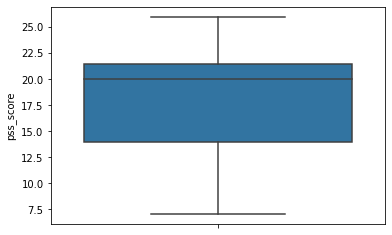

In [ ]:
sns.boxplot( y=dfRefined['pss_score'] )

### Standard deviation

In [ ]:
std_dev = min_val = dfRefined['pss_score'].std()
std_dev

5.629392372142145

### User count in each category [low, moderate, high]

In [ ]:
category_count = dfRefined['pss_stress_level'].value_counts()
print(category_count)

moderate    15
low          4
Name: pss_stress_level, dtype: int64


### Skewness chart

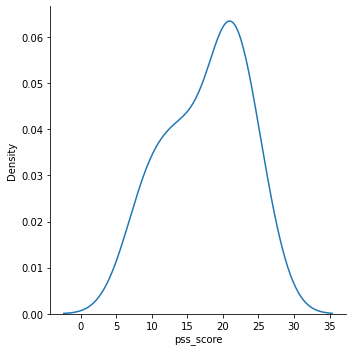

In [ ]:
sns.displot(data=dfRefined, x="pss_score", kind='kde')

### Kurtosis & Skew values

In [ ]:
skew = dfRefined['pss_score'].skew()
kurt = dfRefined['pss_score'].kurtosis()
print('kurtosis', kurt, 'skew', skew)

kurtosis -0.9745455629630428 skew -0.4070794818416531


## Download and process .zip files of Facebook data

### function to download zip file by id

In [ ]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download" 
    

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

### Iterate DataFrame and download each user's zip file

In [ ]:
from urllib.parse import urlparse, parse_qs

for ind in df.index:
    username = f'Subject_{ind}'
    filename = f'{username}.zip'
    dfRefined.loc[ind, 'user'] = username

    #downloads zip file of each user
    parsed_url = urlparse(df['zip'][ind]);
    zipID = (parse_qs(parsed_url.query))['id'][0]
    download_file_from_google_drive(zipID, filename)

dfRefined.head()

,pss_score,pss_stress_level,user
0,14,moderate,Subject_0
1,15,moderate,Subject_1
2,15,moderate,Subject_2
3,21,moderate,Subject_3
4,23,moderate,Subject_4


### Read and insert Status & Comments into DataFrame

#### function: clean data of any foreign characters, and convert to lower-case

In [ ]:
def cleanStr(s):
    x = re.sub('[^a-zA-Z0-9-_*.]', ' ', s)
    return " ".join(x.split()).lower()

#### loop through dataframe: read each ZIP file and create a TXT file corresponding to each user
#### Add empath score to dataframe

In [ ]:
lexicon = Empath()

for ind in dfRefined.index:
    username = dfRefined['user'][ind]
    filename = f'{username}.zip'
    isValidZipFile = zipfile.is_zipfile(filename)
    textList = []
    if(isValidZipFile):
        z = zipfile.ZipFile(filename, 'r')
        
        # print(z.namelist())
        if 'comments/comments.json' in z.namelist():
            # print('has comments', username)
            with z.open('comments/comments.json') as f:
                data = f.read()
                d = json.loads(data.decode("utf-8"))
                comList = d["comments"]
                for i in range(len(comList)):
                    if 'data' in comList[i].keys():
                        dList = comList[i]["data"]
                        for j in range(len(dList)):
                            t = dList[j]['comment']['comment']
                            textList.append(dList[j]['comment']['comment'])
        if 'posts/your_posts_1.json' in z.namelist():
            # print('has status', username)
            with z.open('posts/your_posts_1.json') as f:
                data = f.read()
                d = json.loads(data.decode("utf-8"))
                for i in range(len(d)):
                    if 'data' in d[i].keys():
                        dList = d[i]["data"]
                        for j in range(len(dList)):
                            t = (dList[j]['post']) if('post' in dList[j]) else ''
                            textList.append(t)
    textStr = '\n'.join(textList)
    # dfRefined.loc[ind, 'text'] = textStr

    newList = []
    for l in textList:
        newList.append(cleanStr(l))
    
    f = open(f'{username}.txt', "w")
    f.write('\n'.join(newList))
    f.close()

    zipObj = zipfile.ZipFile('return_data.zip', 'a')
    zipObj.write(f'{username}.txt')
    zipObj.close()

    empath_dict = lexicon.analyze('\n'.join(newList), normalize=True)
    for x in empath_dict or {}:
        dfRefined.loc[ind, x] = empath_dict[x]


dfRefined.head()



,pss_score,pss_stress_level,user,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,cheerfulness,aggression,occupation,envy,anticipation,family,vacation,crime,attractive,masculine,prison,health,pride,dispute,nervousness,government,weakness,horror,swearing_terms,leisure,suffering,royalty,wealthy,tourism,furniture,school,magic,...,car,strength,technology,breaking,shape_and_size,power,white_collar_job,animal,party,terrorism,smell,disappointment,poor,plant,pain,beauty,timidity,philosophy,negotiate,negative_emotion,cleaning,messaging,competing,law,friends,payment,achievement,alcohol,liquid,feminine,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
0,14,moderate,Subject_0,0.00000,0.000000,0.0,0.00000,0.30000,0.0,0.000000,0.0,0.0,0.0,0.15,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.30000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.15,0.00000
1,15,moderate,Subject_1,0.00641,0.003205,0.0,0.00641,0.00641,0.0,0.003205,0.0,0.0,0.0,0.00,0.0,0.003205,0.0,0.0,0.003205,0.003205,0.00641,0.0,0.003205,0.003205,0.0,0.0,0.003205,0.0,0.003205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003205,0.003205,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.003205,0.003205,0.0,0.00641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003205,0.003205,0.003205,0.012821,0.0,0.0,0.003205,0.003205,0.00641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003205,0.0,0.0,0.0,0.00,0.00641
2,15,moderate,Subject_2,0.00641,0.003205,0.0,0.00641,0.00641,0.0,0.003205,0.0,0.0,0.0,0.00,0.0,0.003205,0.0,0.0,0.003205,0.003205,0.00641,0.0,0.003205,0.003205,0.0,0.0,0.003205,0.0,0.003205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003205,0.003205,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.003205,0.003205,0.0,0.00641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003205,0.003205,0.003205,0.012821,0.0,0.0,0.003205,0.003205,0.00641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003205,0.0,0.0,0.0,0.00,0.00641
3,21,moderate,Subject_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23,moderate,Subject_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### export dataframe to csv

In [ ]:
dfRefined.to_csv('export.csv')

### Download processed data in zip file

In [ ]:
zipObj = zipfile.ZipFile('return_data.zip', 'a')
zipObj.write('export.csv')
zipObj.close()

from google.colab import files
files.download('export.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>